# PPOとSACを実装し，学習させてみよう！


 この演習では，**Proximal Policy Optimization(PPO)**[[1]](#scrollTo=HOq7n-OJboPr)と**Soft Actor-Critic(SAC)**[[2,3]](#scrollTo=HOq7n-OJboPr)を実装し，`InvertedPendulumBulletEnv-v0` と `HalfCheetahBulletEnv-v0` の2つの環境で学習させていきます．

0. [準備](#scrollTo=TZIymOlD4K7n)
1. [タスクの概要](#scrollTo=c4eanX0pKgcr)
2. [予備知識](#scrollTo=_7awwWKC4UXj)
3. [Proximal Policy Optimization(PPO)の実装](#scrollTo=e6tuB-Ed4ULy)
4. [Soft Actor-Critic(SAC)の実装](#scrollTo=o5ODWC9LMx2Q)
5. [参考文献](#scrollTo=HOq7n-OJboPr)


## 0.準備

演習を行うために必要な準備をしていきましょう．

In [1]:
# 必要なライブラリのインポート．
from abc import ABC, abstractmethod
import os
import glob
from collections import deque
from time import time
from datetime import timedelta
import pickle
from base64 import b64encode
import math
import numpy as np
import torch
from torch import nn
from torch.distributions import Normal
import torch.nn.functional as F
import gym
import matplotlib.pyplot as plt
from IPython.display import HTML

# Gymの警告を一部無視する．
gym.logger.set_level(40)
# matplotlibをColab上で描画するためのコマンド．
%matplotlib inline

この課題では，[PyBullet](https://github.com/bulletphysics/bullet3)を用いて物理シミュレーションを行います．PyBulletは `pip` を用いてインストールしましょう．

In [2]:
# pipを用いてPyBulletをインストール．
!pip install pybullet
import pybullet_envs

ランタイムをGPUに変更していますか？GPUを利用できているか，きちんと確認しましょう．

In [3]:
!nvidia-smi

'nvidia-smi' は、内部コマンドまたは外部コマンド、
操作可能なプログラムまたはバッチ ファイルとして認識されていません。


In [4]:
torch.cuda.is_available()

True

In [5]:
torch.__version__

'1.6.0'

## 1.タスクの概要

この演習で利用するタスク `InvertedPendulumBulletEnv-v0` と `HalfCheetahBulletEnv-v0` の環境を可視化してみましょう！

1ステップごとにレンダリングを行い，リアルタイムで可視化することも可能ですが，colab上では非常にカクカクしてしまいます．この演習では1エピソード全体をmp4に保存してから再生することにします．まず可視化のための関数を定義します．

In [6]:
def wrap_monitor(env):
    """ Gymの環境をmp4に保存するために，環境をラップする関数． """
    return gym.wrappers.Monitor(env, '/tmp/monitor', video_callable=lambda x: True, force=True)

def play_mp4():
    """ 保存したmp4をHTMLに埋め込み再生する関数． """
    path = glob.glob(os.path.join('/tmp/monitor', '*.mp4'))[0]
    mp4 = open(path, 'rb').read()
    url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""<video width=400 controls><source src="%s" type="video/mp4"></video>""" % url)

### 1.1 InvertedPendulumBulletEnv-v0

まず `InvertedPendulumBulletEnv-v0` をランダム方策で動かしてみましょう．

この環境では状態空間は5次元の実数 $\mathcal R^5$ ，行動空間は1次元の実数 $[-1,1]$ です．ランダム方策では倒立振子がすぐに倒れてしまい，エピソードが終了してしまっていることがわかります．

In [7]:
env = gym.make('InvertedPendulumBulletEnv-v0')
env = wrap_monitor(env)

print('observation space: ', env.observation_space)
print('action space: ', env.action_space)

env.reset()
done = False

# 終了シグナル(done=True)が返ってくるまで，ランダムに環境を動かす．
while (not done):
  action = env.action_space.sample()
  _, _, done, _ = env.step(action)

del env

play_mp4()

observation space:  Box(5,)
action space:  Box(1,)


### 1.2 HalfCheetahBulletEnv-v0

次に `HalfCheetahBulletEnv-v0` をランダム方策で動かしてみましょう．

この環境では状態空間は26次元の実数 $\mathcal R^{26}$，行動空間は6次元の $[-1,1]^6$ です．ランダム方策では，cheetahは全く前に進むことができないことがわかります．また，この環境ではエピソード失敗の概念がなく，倒れ込んでしまっても最大ステップ数に達するまでエピソードは終了しません．

In [8]:
env = gym.make('HalfCheetahBulletEnv-v0')
env = wrap_monitor(env)

print('observation space: ', env.observation_space)
print('action space: ', env.action_space)

env.reset()
done = False

# 終了シグナル(done=True)が返ってくるまで，ランダムに環境を動かす．
while (not done):
  action = env.action_space.sample()
  _, _, done, _ = env.step(action)

del env

play_mp4()

observation space:  Box(26,)
action space:  Box(6,)


## 2.予備知識

### 2.1 講義内容のおさらい

**TODO: 強化学習全般(方策勾配法・Actor-Critic)やPPO・SACに関する簡単な説明**

### 2.2 実装の概要

この演習では，一定のステップ間データ収集・学習・評価を繰り返す `Trainer` クラスを利用します．今回は実装済みのものを利用しますが，このクラスでは強化学習の大まかな流れを実装しているので，ぜひ参照してみてください．

In [9]:
class Trainer:

    def __init__(self, env, env_test, algo, seed=0, num_steps=10**6, eval_interval=10**4, num_eval_episodes=3):

        self.env = env
        self.env_test = env_test
        self.algo = algo

        # 環境の乱数シードを設定する．
        self.env.seed(seed)
        self.env_test.seed(2**31-seed)

        # 平均収益を保存するための辞書．
        self.returns = {'step': [], 'return': []}

        # データ収集を行うステップ数．
        self.num_steps = num_steps
        # 評価の間のステップ数(インターバル)．
        self.eval_interval = eval_interval
        # 評価を行うエピソード数．
        self.num_eval_episodes = num_eval_episodes

    def train(self):
        """ num_stepsステップの間，データ収集・学習・評価を繰り返す． """

        # 学習開始の時間
        self.start_time = time()
        # エピソードのステップ数．
        t = 0

        # 環境を初期化する．
        state = self.env.reset()

        for steps in range(1, self.num_steps + 1):
            # 環境(self.env)，現在の状態(state)，現在のエピソードのステップ数(t)，今までのトータルのステップ数(steps)を
            # アルゴリズムに渡し，状態・エピソードのステップ数を更新する．
            state, t = self.algo.step(self.env, state, t, steps)

            # アルゴリズムが準備できていれば，1回学習を行う．
            if self.algo.is_update(steps):
                self.algo.update()

            # 一定のインターバルで評価する．
            if steps % self.eval_interval == 0:
                self.evaluate(steps)

    def evaluate(self, steps):
        """ 複数エピソード環境を動かし，平均収益を記録する． """

        returns = []
        for _ in range(self.num_eval_episodes):
            state = self.env_test.reset()
            done = False
            episode_return = 0.0

            while (not done):
                action = self.algo.exploit(state)
                state, reward, done, _ = self.env_test.step(action)
                episode_return += reward

            returns.append(episode_return)

        mean_return = np.mean(returns)
        self.returns['step'].append(steps)
        self.returns['return'].append(mean_return)

        print(f'Num steps: {steps:<6}   '
              f'Return: {mean_return:<5.1f}   '
              f'Time: {self.time}')

    def visualize(self):
        """ 1エピソード環境を動かし，mp4を再生する． """
        env = wrap_monitor(gym.make(self.env.unwrapped.spec.id))
        state = env.reset()
        done = False

        while (not done):
            action = self.algo.exploit(state)
            state, _, done, _ = env.step(action)

        del env
        return play_mp4()

    def plot(self):
        """ 平均収益のグラフを描画する． """
        fig = plt.figure(figsize=(8, 6))
        plt.plot(self.returns['step'], self.returns['return'])
        plt.xlabel('Steps', fontsize=24)
        plt.ylabel('Return', fontsize=24)
        plt.tick_params(labelsize=18)
        plt.title(f'{self.env.unwrapped.spec.id}', fontsize=24)
        plt.tight_layout()

    @property
    def time(self):
        """ 学習開始からの経過時間． """
        return str(timedelta(seconds=int(time() - self.start_time)))

次章以降では，以下の抽象クラスを継承して，PPOとSACのアルゴリズムを記述したアルゴリズム(Trainerの `self.algo`の部分)を実装し，強化学習の処理を完成させていきます！

In [10]:
class Algorithm(ABC):

    def explore(self, state):
        """ 確率論的な行動と，その行動の確率密度の対数 \log(\pi(a|s)) を返す． """
        state = torch.tensor(state, dtype=torch.float, device=self.device).unsqueeze_(0)
        with torch.no_grad():
            action, log_pi = self.actor.sample(state)
        return action.cpu().numpy()[0], log_pi.item()

    def exploit(self, state):
        """ 決定論的な行動を返す． """
        state = torch.tensor(state, dtype=torch.float, device=self.device).unsqueeze_(0)
        with torch.no_grad():
            action = self.actor(state)
        return action.cpu().numpy()[0]

    @abstractmethod
    def is_update(self, steps):
        """ 現在のトータルのステップ数(steps)を受け取り，アルゴリズムを学習するか否かを返す． """
        pass

    @abstractmethod
    def step(self, env, state, t, steps):
        """ 環境(env)，現在の状態(state)，現在のエピソードのステップ数(t)，今までのトータルのステップ数(steps)を
            受け取り，リプレイバッファへの保存などの処理を行い，状態・エピソードのステップ数を更新する．
        """
        pass

    @abstractmethod
    def update(self):
        """ 1回分の学習を行う． """
        pass

## 3.Proximal Policy Optimization(PPO)の実装

#### 3.1 [演習] 方策計算のための関数の実装

今回の演習では **共分散行列が対角なガウス分布に $\tanh$ を適用した確率分布** をPPO・SACの方策として用います．以下では，共分散行列が対角なガウス分布を単にガウス分布と呼び，共分散行列の対角成分の平方根を単に標準偏差と呼ぶことにします．また，括弧で囲んだ表記 `(...)` は，TensorのSizeを表すことにします．

方策は，学習時に探索を行うための**確率論的な行動選択**と，評価時に最適な行動を行うための**決定論的な行動選択**の2種類の行動選択を行います．確率論的な行動選択ではガウス分布からのサンプルに $\tanh$ を適用したものを，決定論的な行動選択ではガウス分布の最頻値(平均)に $\tanh$ を適用したものを行動とします．

まず，確率論的な行動を計算した際の行動の確率密度の対数 $\log \pi(a|s)$ を求める関数 `calculate_log_pi(log_stds, noises, actions)` を実装しましょう．ただし，引数の `log_stds` (標準偏差の対数)，`noises` (Reparametrization Trickにおける標準ガウス分布からのノイズ)，`actions` (行動)はすべて `(batch_size, |A|)` とし，行動の確率密度の対数は `(batch_size, 1)` で返します．



(ヒント) Reparameterization Trickでは，標準ガウス分布からのノイズ $\epsilon \sim \mathcal N(0, I)$ を用いて，平均 $\mu$，標準偏差 $\sigma$ からのサンプルを以下のように計算します．

$$ u = \mu + \epsilon * \sigma $$ $$ a = \tanh(u) $$

【余力がある人向け】

確率密度関数は平行移動に関して不変なので，ガウス分布からのサンプル $u$ の確率密度 $p(u|s)$ は $\mathcal N(0, \sigma I)$ における $\epsilon * \sigma$ の確率密度として計算することができます．その後，$\tanh$ による確率密度の変化を以下のように修正してあげましょう．

確率密度関数 $\pi(a|s)$ は $$ \pi(a|s) = \biggl|\frac{du}{da}\biggl|p(u|s) = \frac{1}{1-a^2}p(u|s) $$

$\log$ をとると $$ \begin{align} \log\pi(a|s) &= \log p(u|s) - \sum_{i=1}^{|\mathcal A|} \log (1 - a^{2}) \end{align} $$

(各actionの要素での確率の積にlogがかかったものを計算するので、総和をとります)

In [11]:
def calculate_log_pi(log_stds, noises, actions):
    """ 確率論的な行動の確率密度を返す． """

    # NOTE: 入力はすべて (batch_size, |A|) となっているので，この関数では　batch_size　分の確率密度の対数 \log \pi(a|s) を
    # それぞれ独立に計算し (batch_size, 1) で返します．

    # ガウス分布 `N(0, stds * I)` における `noises * stds` の確率密度の対数(= \log \pi(u|a))を計算する．
    stds = log_stds.exp()
    gaussian_log_probs = Normal(torch.zeros_like(stds), stds).log_prob(stds * noises).sum(dim=-1, keepdim=True)

    # NOTE: gaussian_log_probs には (batch_size, 1) で表された確率密度の対数 \log p(u|s) が入っています．

    # [演習] その後，tanh による確率密度の変化を修正しましょう．
    # (例)
    # log_pis = gaussian_log_probs - ...
    log_pis = gaussian_log_probs - torch.log(1 - actions.pow(2) + 1e-6).sum(dim=-1, keepdim=True)
    
    return log_pis

次に，Reparameterization Trickを用いて，確率的な行動 $a = \tanh(\mu + \epsilon * \sigma)$ とその行動の確率密度の対数 $\log \pi(a|s)$ を計算する関数 `reparameterize(means, log_stds)` を実装しましょう．ただし，引数の `means` (平均)と `log_stds` (標準偏差の対数)は `(batch_size, |A|)` とし，行動は `(batch_size, |A|)`，確率密度の対数は `(batch_size, 1)` で返します．

In [14]:
def reparameterize(means, log_stds):
    """ Reparameterization Trickを用いて，確率論的な行動とその確率密度を返す． """

    # 標準偏差．
    stds = log_stds.exp()

    # [演習] Reparameterization Trickを用いて，標準ガウス分布からノイズをサンプリングし，確率論的な行動を計算しましょう．
    # (例)
    # noises = ...
    # actions = ...
    noises = torch.randn_like(means)
    us = means + noises * stds
    actions = torch.tanh(us)

    # 確率論的な行動の確率密度の対数を計算する．
    log_pis = calculate_log_pi(log_stds, noises, actions)

    return actions, log_pis

また，のちのち簡単に方策を実装できるように，ある平均・標準偏差の対数でパラメータ化したガウス分布 + $\tanh$ の方策における，ある行動の確率密度の対数を計算する関数 `evaluate_lop_pi(means, log_stds, actions)` をあらかじめ定義しておきます．

In [15]:
def atanh(x):
    """ tanh の逆関数． """
    return 0.5 * (torch.log(1 + x + 1e-6) - torch.log(1 - x + 1e-6))


def evaluate_lop_pi(means, log_stds, actions):
    """ 平均(mean)，標準偏差の対数(log_stds)でパラメータ化した方策における，行動(actions)の確率密度の対数を計算する． """
    noises = (atanh(actions) - means) / (log_stds.exp() + 1e-8)
    return calculate_log_pi(log_stds, noises, actions)

### 3.2 [演習] ネットワークの実装

PPOの方策では，ユニット数64の隠れ層を2層もち，中間層の活性化関数に $\tanh$ を用いたネットワークを構築します．このネットワークは，入力として状態を受け取り，**ガウス分布の平均**を出力します．また**ガウス分布の標準偏差の対数**を，学習するパラメータとして保持します．

では早速，PPOの方策を関数近似するネットワークのクラス `PPOActor` を実装しましょう！ここでは，以下の4つのメソッドを実装します．

- `__init__(self, state_shape, action_shape)`

> 入力として状態を受け取り，**ガウス分布の平均**を出力するネットワークを構築します．また，**ガウス分布の標準偏差の対数**を表すパラメータを作成します．

- `forward(self, states)`

> `(batch_size, |S|)` の `states` を受け取り，決定論な行動 $a$ を `(batch_size, 1)`で返します．

- `sample(self, states)`

> `(batch_size, |S|)` の `states` を受け取り，確率論的な行動 $a$ とその行動の確率密度の対数 $\log(\pi(a|s))$ をそれぞれ `(batch_size, 1)` で返します．

- `evaluate_log_pi(self, states, actions)`

> `(batch_size, |S|)` の `states` と，`(batch_size, |A|)` の `actions` を受け取り，現在の方策における行動 `actions` の確率密度の対数を `(batch_size, 1)` で返します．


In [17]:
class PPOActor(nn.Module):

    def __init__(self, state_shape, action_shape):
        super().__init__()

        # 状態を受け取り，ガウス分布の平均を出力するネットワークを構築します
        self.net = nn.Sequential(
            nn.Linear(state_shape[0], 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, action_shape[0]),
        )

        # ガウス分布の標準偏差の対数を表す，学習するパラメータを作成します．
        self.log_stds = nn.Parameter(torch.zeros(1, action_shape[0]))

    def forward(self, states):
        # [演習] 決定論的な行動を計算し，返します．
        # return ...
        return torch.tanh(self.net(states))

    def sample(self, states):
        # [演習] 確率論的な行動と確率密度の対数を計算し，返します．
        # (例)
        # actions, log_pis = reparameterize(...)
        # return actions, log_pis
        return reparameterize(self.net(states), self.log_stds)

    def evaluate_log_pi(self, states, actions):
        # 現在の方策における行動 actions の確率密度の対数を計算し，返します．
        return evaluate_lop_pi(self.net(states), self.log_stds, actions)

続いて，PPOの状態価値を関数近似するネットワークのクラス `PPOCritic` を実装しましょう．このネットワークも，ユニット数64の隠れ層を2層もち，中間層の活性化関数に $\tanh$ を用います．入力として状態を受け取り，状態価値を出力します．

では，以下の2つのメソッドを実装しましょう．

- `__init__(self, state_shape)`

> 入力として状態受け取り，状態価値を出力するネットワークを構築します．

- `forward(self, states)`

> `(batch_size, |S|)` の `states` を受け取り，状態価値を `(batch_size, 1)` で返します．




In [20]:
class PPOCritic(nn.Module):

    def __init__(self, state_shape):
        super().__init__()

        # [演習] 状態を受け取り，状態価値を出力するネットワークを構築しましょう．
        # (例)
        # self.net = ...
        self.net = nn.Sequential(
            nn.Linear(state_shape[0], 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1),
        )

    def forward(self, states):
        # [演習] 状態価値を計算し，返します．
        # return ...
        return self.net(states)

### 3.3 Generalized Advantage Estimation(GAE)の実装

PPOでは，アドバンテージの推定に**Generalized Advantage Estimation**(GAE)[[4]](#scrollTo=HOq7n-OJboPr)を用います．GAEではnステップのアドバンテージ $\hat A_t^{(n)} = r_t + \gamma r_{t+1} + \cdots + \gamma^n V(s_{t+n}) - V(s_t)$ を用いて，以下のようにアドバンテージを推定します．

$$
\hat A_t^{GAE}(\lambda) = (1-\lambda)(\hat A_t^{(1)} + \lambda \hat A_t^{(2)} + \lambda^2 \hat A_t^{(3)} + \cdots)
$$

このとき，TD誤差 $\delta_t= r_t+ \gamma V(s_{t+1}) - V(s_t)$ を用いると，以下のように式変形できます．(発展課題で導出に挑戦してみましょう！)

$$
\hat A_t^{GAE}(\lambda) = \sum_{i=0}^{\infty} (\gamma \lambda)^i \delta_{t+i}
$$

従って，GAEは再帰的に計算することが可能です．ただし，実際にはロールアウト長を $T$ としたときに，$t = T + 1$ 以降のGAEをすべて $0$ と近似して計算を行います．

$$
\hat A_t^{GAE}(\lambda) = \delta_t + (\gamma \lambda) \hat A_{t+1}^{GAE}(\lambda)
$$

\\
またPPOでは，状態価値のターゲットを $\lambda$-収益 $R_t(\lambda)$ を用いて推定します．

$$
R_t(\lambda) = \hat A_t^{GAE}(\lambda) + V(s_t)
$$


In [21]:
def calculate_advantage(values, rewards, dones, gamma=0.995, lambd=0.997):
    """ GAEを用いて，状態価値のターゲットとGAEを計算する． """

    # TD誤差を計算する．
    deltas = rewards + gamma * values[1:] * (1 - dones) - values[:-1]

    # GAEを初期化する．
    advantages = torch.empty_like(rewards)

    # 終端ステップを計算する．
    advantages[-1] = deltas[-1]

    # 終端ステップの1つ前から，順番にGAEを計算していく．
    for t in reversed(range(rewards.size(0) - 1)):
        advantages[t] = deltas[t] + gamma * lambd * (1 - dones[t]) * advantages[t + 1]

    # 状態価値のターゲットをλ-収益として計算する．
    targets = advantages + values[:-1]

    # GAEを標準化する．
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    return targets, advantages

### 3.4 [演習] 学習アルゴリズム(PPO)の実装

まず，収集したデータを保存するためのバッファを用意します．ここでは，状態・行動・即時報酬・終了シグナル・確率密度の対数をロールアウト1回分保存することとします．このとき，状態のみ1つ分多く保存することに注意します(GAEの計算では，1ステップ先の状態価値を計算する必要があるので)．

In [22]:
class RolloutBuffer:

    def __init__(self, buffer_size, state_shape, action_shape, device=torch.device('cuda')):

        # GPU上に保存するデータ．
        self.states = torch.empty((buffer_size + 1, *state_shape), dtype=torch.float, device=device)
        self.actions = torch.empty((buffer_size, *action_shape), dtype=torch.float, device=device)
        self.rewards = torch.empty((buffer_size, 1), dtype=torch.float, device=device)
        self.dones = torch.empty((buffer_size, 1), dtype=torch.float, device=device)
        self.log_pis = torch.empty((buffer_size, 1), dtype=torch.float, device=device)

        # 次にデータを挿入するインデックス．
        self._p = 0
        # バッファのサイズ．
        self.buffer_size = buffer_size

    def append(self, state, action, reward, done, log_pi):
        self.states[self._p].copy_(torch.from_numpy(state))
        self.actions[self._p].copy_(torch.from_numpy(action))
        self.rewards[self._p] = float(reward)
        self.dones[self._p] = float(done)
        self.log_pis[self._p] = float(log_pi)
        self._p = (self._p + 1) % self.buffer_size

    def append_last_state(self, last_state):
        assert self._p == 0, 'Buffer needs to be full before appending last_state.'
        self.states[self.buffer_size].copy_(torch.from_numpy(last_state))

    def get(self):
        assert self._p == 0, 'Buffer needs to be full before training.'
        return self.states, self.actions, self.rewards, self.dones, self.log_pis

では，いよいよPPOの学習アルゴリズムを実装していきましょう！

今回の演習では，`update_critic` と `update_actor` の2つのメソッドを実装します．以下では，方策のネットワークのパラメータを $\phi$，状態価値のネットワークのパラメータを $\theta$ とします．また，ロールアウト長を $T$ とします．

- `update_critic(self, states, targets)`

> `(batch_size, |S|)` の `states` (状態)と `(batch_size, 1)` の `targets` (状態価値のターゲット)を受け取り，Criticのネットワークを更新します．

> 状態価値のネットワークの損失関数は **平均二乗誤差** を用います．

$$
\mathcal L^{PPO}_V(\theta) = E_{t \in [1, T]}[ (V_\theta(s_t) - R_t(\lambda))^2 ]
$$

- `update_actor(self, states, actions, log_pis_old, advantages)`

> `(batch_size, |S|)` の `states` (状態)と `(batch_size, |A|)` の `actions` (行動)，そして `(batch_size, 1)` の `log_pis_old` (データ収集時の方策における行動の確率密度)と `advantages` (GAE)を受け取り，Actorのネットワークを更新します．

> 方策のネットワークの損失関数は，以下の式を用います．ただし，過去の方策のネットワークのパラメータを $\phi_{old}$ とします．また，損失関数の $\epsilon$ は `self.clip_eps` に保持されています．

$$
\mathcal L^{PPO}_\pi(\phi) = E_{t \in [1, T]}[ \min(\frac{\pi_\phi(a_t|s_t)}{\pi_{\phi_{old}}(a_t|s_t)}\hat A_t^{GAE}(\lambda), \; clip(\frac{\pi_\phi(a_t|s_t)}{\pi_{\phi_{old}}(a_t|s_t)}, 1-\epsilon, 1+\epsilon) \hat A_t^{GAE}(\lambda) ]
$$



In [24]:
class PPO(Algorithm):

    def __init__(self, state_shape, action_shape, device=torch.device('cuda'), seed=0,
                 batch_size=64, gamma=0.995, lr_actor=3e-4, lr_critic=3e-4,
                 rollout_length=2048, num_updates=10, clip_eps=0.2, lambd=0.97,
                 coef_ent=0.0, max_grad_norm=0.5):
        super().__init__()

        # シードを設定する．
        np.random.seed(seed)
        torch.manual_seed(seed)

        # データ保存用のバッファ．
        self.buffer = RolloutBuffer(
            buffer_size=rollout_length,
            state_shape=state_shape,
            action_shape=action_shape,
            device=device
        )

        # Actor-Criticのネットワークを構築する．
        self.actor = PPOActor(
            state_shape=state_shape,
            action_shape=action_shape,
        ).to(device)
        self.critic = PPOCritic(
            state_shape=state_shape,
        ).to(device)

        # オプティマイザ．
        self.optim_actor = torch.optim.Adam(self.actor.parameters(), lr=lr_actor)
        self.optim_critic = torch.optim.Adam(self.critic.parameters(), lr=lr_critic)

        # その他パラメータ．
        self.learning_steps = 0
        self.device = device
        self.batch_size = batch_size
        self.gamma = gamma
        self.rollout_length = rollout_length
        self.num_updates = num_updates
        self.clip_eps = clip_eps
        self.lambd = lambd
        self.coef_ent = coef_ent
        self.max_grad_norm = max_grad_norm

    def is_update(self, steps):
        # ロールアウト1回分のデータが溜まったら学習する．
        return steps % self.rollout_length == 0

    def step(self, env, state, t, steps):
        t += 1

        action, log_pi = self.explore(state)
        next_state, reward, done, _ = env.step(action)

        # ゲームオーバーではなく，最大ステップ数に到達したことでエピソードが終了した場合は，
        # 本来であればその先もMDPが継続するはず．よって，終了シグナルをFalseにする．
        if t == env._max_episode_steps:
            done_masked = False
        else:
            done_masked = done

        # バッファにデータを追加する．
        self.buffer.append(state, action, reward, done_masked, log_pi)

        # ロールアウトの終端に達したら，最終状態をバッファに追加する．
        if steps % self.rollout_length == 0:
            self.buffer.append_last_state(next_state)

        # エピソードが終了した場合には，環境をリセットする．
        if done:
            t = 0
            next_state = env.reset()

        return next_state, t

    def update(self):
        self.learning_steps += 1

        states, actions, rewards, dones, log_pis = self.buffer.get()

        with torch.no_grad():
            values = self.critic(states)
        targets, advantages = calculate_advantage(values, rewards, dones, self.gamma, self.lambd)

        # バッファ内のデータを num_updates回ずつ使って，ネットワークを更新する．
        for _ in range(self.num_updates):
            # インデックスをシャッフルする．
            indices = np.arange(self.rollout_length)
            np.random.shuffle(indices)

            # ミニバッチに分けて学習する．
            for start in range(0, self.rollout_length, self.batch_size):
                idxes = indices[start:start+self.batch_size]
                self.update_critic(states[idxes], targets[idxes])
                self.update_actor(states[idxes], actions[idxes], log_pis[idxes], advantages[idxes])

    def update_critic(self, states, targets):
        # [演習] 状態価値のネットワークの損失関数を計算しましょう．
        # (例)
        # loss_critic = ... self.critic(...) ...
        loss_critic = (self.critic(states) - targets).pow_(2).mean()
        
        self.optim_critic.zero_grad()
        loss_critic.backward(retain_graph=False)
        # 学習を安定させるヒューリスティックとして，勾配のノルムをクリッピングする．
        nn.utils.clip_grad_norm_(self.critic.parameters(), self.max_grad_norm)
        self.optim_critic.step()

    def update_actor(self, states, actions, log_pis_old, advantages):
        # [演習] 方策のネットワークの損失関数を計算しましょう．
        # (例)
        # loss_actor = ... self.actor ...
        log_pis = self.actor.evaluate_log_pi(states, actions)
        mean_entropy = -log_pis.mean()

        ratios = (log_pis - log_pis_old).exp_()
        loss_actor1 = -ratios * advantages
        loss_actor2 = -torch.clamp(
            ratios,
            1.0 - self.clip_eps,
            1.0 + self.clip_eps
        ) * advantages
        loss_actor = torch.max(loss_actor1, loss_actor2).mean() - self.coef_ent * mean_entropy

        self.optim_actor.zero_grad()
        loss_actor.backward(retain_graph=False)
        # 学習を安定させるヒューリスティックとして，勾配のノルムをクリッピングする．
        nn.utils.clip_grad_norm_(self.actor.parameters(), self.max_grad_norm)
        self.optim_actor.step()

### 3.5 実験

それでは，実装したPPOを学習させてみましょう！

#### InvertedPendulumBulletEnv-v0



まず，`InvertedPendulumBulletEnv-v0` でPPOを $5 \times 10^4$ ステップ学習させてみましょう！学習には3~5分ほどかかります．うまく学習できると，平均収益が1000に達します．

In [25]:
ENV_ID = 'InvertedPendulumBulletEnv-v0'
SEED = 0
NUM_STEPS = 5 * 10 ** 4
EVAL_INTERVAL = 10 ** 3

env = gym.make(ENV_ID)
env_test = gym.make(ENV_ID)

algo = PPO(
    state_shape=env.observation_space.shape,
    action_shape=env.action_space.shape,
    seed=SEED
)

trainer = Trainer(
    env=env,
    env_test=env_test,
    algo=algo,
    seed=SEED,
    num_steps=NUM_STEPS,
    eval_interval=EVAL_INTERVAL,
)

In [26]:
trainer.train()

Num steps: 1000     Return: 17.3    Time: 0:00:01
Num steps: 2000     Return: 18.0    Time: 0:00:02
Num steps: 3000     Return: 18.0    Time: 0:00:05
Num steps: 4000     Return: 26.0    Time: 0:00:06
Num steps: 5000     Return: 39.3    Time: 0:00:08
Num steps: 6000     Return: 42.7    Time: 0:00:09
Num steps: 7000     Return: 200.3   Time: 0:00:12
Num steps: 8000     Return: 183.0   Time: 0:00:13
Num steps: 9000     Return: 173.0   Time: 0:00:16
Num steps: 10000    Return: 229.3   Time: 0:00:17
Num steps: 11000    Return: 172.0   Time: 0:00:20
Num steps: 12000    Return: 217.0   Time: 0:00:21
Num steps: 13000    Return: 188.0   Time: 0:00:24
Num steps: 14000    Return: 166.7   Time: 0:00:25
Num steps: 15000    Return: 224.3   Time: 0:00:28
Num steps: 16000    Return: 148.3   Time: 0:00:29
Num steps: 17000    Return: 231.3   Time: 0:00:32
Num steps: 18000    Return: 158.7   Time: 0:00:33
Num steps: 19000    Return: 170.7   Time: 0:00:36
Num steps: 20000    Return: 186.3   Time: 0:00:37


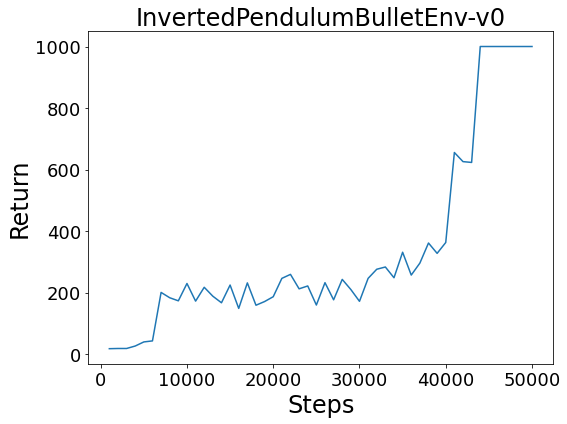

In [27]:
trainer.plot()

In [28]:
trainer.visualize()

In [29]:
del env
del env_test
del algo
del trainer

#### HalfCheetahBulletEnv-v0

次に，`HalfCheetahBulletEnv-v0` でPPOを $10^6$ ステップ学習させてみましょう！ただし，学習には1時間ほどかかるので，`HalfCheetahBulletEnv-v0` での学習は自宅での宿題とします．うまく学習できると，1800〜2400程度の平均収益に達します．

In [30]:
ENV_ID = 'HalfCheetahBulletEnv-v0'
SEED = 0
NUM_STEPS = 10 ** 6
EVAL_INTERVAL = 10 ** 4

env = gym.make(ENV_ID)
env_test = gym.make(ENV_ID)

algo = PPO(
    state_shape=env.observation_space.shape,
    action_shape=env.action_space.shape,
    seed=SEED
)

trainer = Trainer(
    env=env,
    env_test=env_test,
    algo=algo,
    seed=SEED,
    num_steps=NUM_STEPS,
    eval_interval=EVAL_INTERVAL,
)

In [31]:
trainer.train()

Num steps: 10000    Return: -1389.6   Time: 0:00:25
Num steps: 20000    Return: -1287.7   Time: 0:00:53
Num steps: 30000    Return: -1242.7   Time: 0:01:20
Num steps: 40000    Return: -761.5   Time: 0:01:47
Num steps: 50000    Return: -984.0   Time: 0:02:14
Num steps: 60000    Return: -1214.1   Time: 0:02:42
Num steps: 70000    Return: 563.6   Time: 0:03:09
Num steps: 80000    Return: 63.2    Time: 0:03:36
Num steps: 90000    Return: -1235.6   Time: 0:04:02
Num steps: 100000   Return: 78.5    Time: 0:04:29
Num steps: 110000   Return: 527.4   Time: 0:04:55
Num steps: 120000   Return: 683.5   Time: 0:05:22
Num steps: 130000   Return: 785.3   Time: 0:05:48
Num steps: 140000   Return: 850.2   Time: 0:06:15
Num steps: 150000   Return: 872.0   Time: 0:06:41
Num steps: 160000   Return: 872.7   Time: 0:07:07
Num steps: 170000   Return: 873.4   Time: 0:07:34
Num steps: 180000   Return: 865.6   Time: 0:07:59
Num steps: 190000   Return: 873.3   Time: 0:08:25
Num steps: 200000   Return: -1057.2   

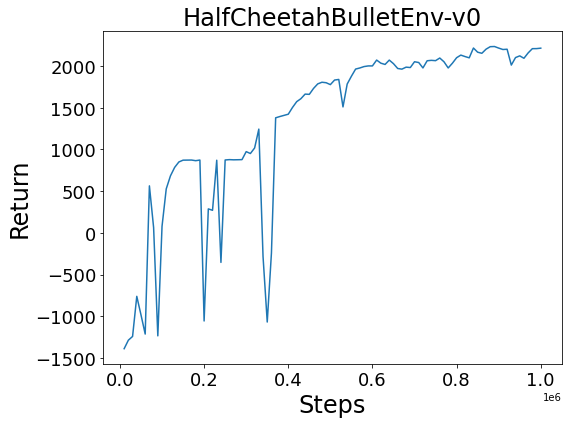

In [32]:
trainer.plot()

In [33]:
trainer.visualize()

In [34]:
del env
del env_test
del algo
del trainer

### 3.6 発展課題

- GAEの再帰式 $\hat A_t^{GAE}(\lambda) = \delta_t + (\gamma \lambda) \hat A_{t+1}^{GAE}(\lambda)$ を導出してみよう！
- PPOの構成要素に関する実験を行った論文[[5]](#scrollTo=HOq7n-OJboPr)を読み，重みの初期化や活性化関数を変更してみよう！

## 4.Soft Actor-Critic(SAC)の実装

### 4.1 [演習] ネットワークの実装

SACの方策では，ユニット数256の隠れ層を2層もち，中間層の活性化関数にReLUを用いたネットワークを構築します．このネットワークは，入力として状態を受け取り，**ガウス分布の平均と標準偏差の対数**を出力します．

では早速，SACの方策を関数近似するネットワークのクラス `SACActor` を実装しましょう！ここでは，PPOと同様の3つのメソッドを実装しましょう．(`evaluate_log_pi` は使わないので実装しません．)

- `__init__(self, state_shape, action_shape)`

> 入力として状態を受け取り，**ガウス分布の平均と標準偏差の対数**を出力するネットワークを構築します．

- `forward(self, states)`

> `(batch_size, |S|)` の `states` を受け取り，決定論な行動 $a$ を `(batch_size, 1)` で返します．

- `sample(self, states)`

> `(batch_size, |S|)` の `states` を受け取り，確率論的な行動 $a$ とその行動の確率密度の対数 $\log(\pi(a|s))$ をそれぞれ `(batch_size, 1)` で返します．ただし，数値計算を安定させるため，ネットワークから出力された**標準偏差の対数を $(-20, 2)$ の範囲にクリッピング**しましょう．


In [35]:
class SACActor(nn.Module):

    def __init__(self, state_shape, action_shape):
        super().__init__()

        # 状態を受け取り，ガウス分布の平均と標準偏差の対数を出力するネットワークを構築します．
        self.net = nn.Sequential(
            nn.Linear(state_shape[0], 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 2 * action_shape[0]),
        )

    def forward(self, states):
        # [演習] 決定論的な行動を計算し，返します．
        # return ...
        return torch.tanh(self.net(states).chunk(2, dim=-1)[0])

    def sample(self, states):
        # [演習] 確率論的な行動と確率密度の対数を計算し，返します．
        # means, log_stds = ...
        # log_stds.clamp_(-20, 2)
        # return ...
        means, log_stds = self.net(states).chunk(2, dim=-1)
        return reparameterize(means, log_stds.clamp_(-20, 2))

続いて，SACのソフト状態行動価値を関数近似するネットワークのクラス `SACCritic` を実装しましょう．ただし，SACでは**Clipped Double Q**というテクニックを用いるため，2つの独立したネットワークを用いて，ソフト状態行動価値を2つ独立に関数近似します．それぞれのネットワークは，ユニット数256の隠れ層を2層もち，中間層の活性化関数にReLUを用います．入力として状態と行動を受け取り，状態価値を出力します．

では，以下の2つのメソッドを実装しましょう．

- `__init__(self, state_shape, action_shape)`

> 入力として状態と行動を受け取り，状態行動価値を出力するネットワークを2つ構築します．

- `forward(self, states, actions)`

> `(batch_size, |S|)` の `states` と `(batch_size, |A|)` の `actions` を受け取り，2つの状態行動価値をそれぞれ `(batch_size, 1)`で返します．



In [36]:
class SACCritic(nn.Module):

    def __init__(self, state_shape, action_shape):
        super().__init__()

        # 状態を受け取り，ソフト状態行動価値を出力するネットワークを2つ構築します．
        self.net1 = nn.Sequential(
            nn.Linear(state_shape[0] + action_shape[0], 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 1),
        )
        self.net2 = nn.Sequential(
            nn.Linear(state_shape[0] + action_shape[0], 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, states, actions):
        # [演習] ソフト状態行動価値を2つ計算し，返します．
        # return ...
        x = torch.cat([states, actions], dim=-1)
        return self.net1(x), self.net2(x)

### 4.2 [演習] 学習アルゴリズム(SAC)の実装

まず，リプレイバッファを用意します．ここでは，状態・行動・即時報酬・終了シグナル・次の状態をGPU上に保存することとします．

In [37]:
class ReplayBuffer:

    def __init__(self, buffer_size, state_shape, action_shape, device):
        # 次にデータを挿入するインデックス．
        self._p = 0
        # データ数．
        self._n = 0
        # リプレイバッファのサイズ．
        self.buffer_size = buffer_size

        # GPU上に保存するデータ．
        self.states = torch.empty((buffer_size, *state_shape), dtype=torch.float, device=device)
        self.actions = torch.empty((buffer_size, *action_shape), dtype=torch.float, device=device)
        self.rewards = torch.empty((buffer_size, 1), dtype=torch.float, device=device)
        self.dones = torch.empty((buffer_size, 1), dtype=torch.float, device=device)
        self.next_states = torch.empty((buffer_size, *state_shape), dtype=torch.float, device=device)

    def append(self, state, action, reward, done, next_state):
        self.states[self._p].copy_(torch.from_numpy(state))
        self.actions[self._p].copy_(torch.from_numpy(action))
        self.rewards[self._p] = float(reward)
        self.dones[self._p] = float(done)
        self.next_states[self._p].copy_(torch.from_numpy(next_state))

        self._p = (self._p + 1) % self.buffer_size
        self._n = min(self._n + 1, self.buffer_size)

    def sample(self, batch_size):
        idxes = np.random.randint(low=0, high=self._n, size=batch_size)
        return (
            self.states[idxes],
            self.actions[idxes],
            self.rewards[idxes],
            self.dones[idxes],
            self.next_states[idxes]
        )

では，いよいよSACの学習アルゴリズムを実装していきましょう！

今回の演習では，`update_critic` と `update_actor` の2つのメソッドを実装します．以下では，方策のネットワークのパラメータを $\phi$，ソフト状態行動価値の2つのネットワークのパラメータを $\theta_i\; (i=1,2)$， ソフト状態行動価値の2つのターゲットネットワークのパラメータを $\bar \theta_i\; (i=1,2)$とします．

- `update_critic(self, states, actions, rewards, dones, next_states)`

> `(batch_size, |S|)` の `states` (状態)と `next_states` (次の状態)，`(batch_size, |A|)` の `actions` (行動)，`(batch_size, 1)` の `rewards` (即時報酬)と `dones` (終了シグナル)を受け取り，ソフト状態行動価値のネットワークを更新します．

> ソフト状態行動価値のネットワークの損失関数は **平均二乗ベルマン誤差** を用います．
$$
\mathcal L^{SAC}_Q(\theta_i) = E_{(s, a, s') \sim D}[(r(s, a) + \gamma V_{\bar\theta}(s') - Q_{\theta_i}(s, a) )^2] \;\; (i=1,2)
$$

>ただし，ソフト状態価値のターゲット $V_{\bar \theta}(s)$ は以下のように計算し，2つのネットワークで同一のターゲットを用いることに注意します．

$$
V_{\bar\theta}(s) = E_{a \sim \pi_{\phi}} [\min_{i=1,2}Q_{\bar \theta_i}(s, a) - \alpha \log \pi_{\phi}(a| s)]
$$

- `update_actor(self, states, actions, log_pis_old, advantages)`

> `(batch_size, |S|)` の `states` (状態)を受け取り，方策のネットワークを更新します．

> 方策のネットワークの損失関数は，以下の式を用います．

$$
L^{SAC}_\pi (\phi) = E_{s \sim D, a \sim \pi_{\phi}} [ \alpha \log \pi_{\phi}(a|s) - \min_{i=1,2} Q_{\theta_i}(s,a) ]
$$

In [38]:
class SAC(Algorithm):

    def __init__(self, state_shape, action_shape, device=torch.device('cuda'), seed=0,
                 batch_size=256, gamma=0.99, lr_actor=3e-4, lr_critic=3e-4,
                 replay_size=10**6, start_steps=10**4, tau=5e-3, alpha=0.2, reward_scale=1.0):
        super().__init__()

        # シードを設定する．
        np.random.seed(seed)
        torch.manual_seed(seed)

        # リプレイバッファ．
        self.buffer = ReplayBuffer(
            buffer_size=replay_size,
            state_shape=state_shape,
            action_shape=action_shape,
            device=device,
        )

        # Actor-Criticのネットワークを構築する．
        self.actor = SACActor(
            state_shape=state_shape,
            action_shape=action_shape
        ).to(device)
        self.critic = SACCritic(
            state_shape=state_shape,
            action_shape=action_shape
        ).to(device)
        self.critic_target = SACCritic(
            state_shape=state_shape,
            action_shape=action_shape
        ).to(device).eval()

        # ターゲットネットワークの重みを初期化し，勾配計算を無効にする．
        self.critic_target.load_state_dict(self.critic.state_dict())
        for param in self.critic_target.parameters():
            param.requires_grad = False

        # オプティマイザ．
        self.optim_actor = torch.optim.Adam(self.actor.parameters(), lr=lr_actor)
        self.optim_critic = torch.optim.Adam(self.critic.parameters(), lr=lr_critic)

        # その他パラメータ．
        self.learning_steps = 0
        self.batch_size = batch_size
        self.device = device
        self.gamma = gamma
        self.start_steps = start_steps
        self.tau = tau
        self.alpha = alpha
        self.reward_scale = reward_scale

    def is_update(self, steps):
        # 学習初期の一定期間(start_steps)は学習しない．
        return steps >= max(self.start_steps, self.batch_size)

    def step(self, env, state, t, steps):
        t += 1

        # 学習初期の一定期間(start_steps)は，ランダムに行動して多様なデータの収集を促進する．
        if steps <= self.start_steps:
            action = env.action_space.sample()
        else:
            action, _ = self.explore(state)
        next_state, reward, done, _ = env.step(action)

        # ゲームオーバーではなく，最大ステップ数に到達したことでエピソードが終了した場合は，
        # 本来であればその先もMDPが継続するはず．よって，終了シグナルをFalseにする．
        if t == env._max_episode_steps:
            done_masked = False
        else:
            done_masked = done

        # リプレイバッファにデータを追加する．
        self.buffer.append(state, action, reward, done_masked, next_state)

        # エピソードが終了した場合には，環境をリセットする．
        if done:
            t = 0
            next_state = env.reset()

        return next_state, t

    def update(self):
        self.learning_steps += 1
        states, actions, rewards, dones, next_states = self.buffer.sample(self.batch_size)

        self.update_critic(states, actions, rewards, dones, next_states)
        self.update_actor(states)
        self.update_target()

    def update_critic(self, states, actions, rewards, dones, next_states):
        # [演習] 現在のソフト状態行動価値とそのターゲットを計算し，ネットワークの損失関数を完成させましょう．
        # (例)
        # 現在のソフト状態行動価値を計算する．
        # curr_qs1, curr_qs2 = ...
        curr_qs1, curr_qs2 = self.critic(states, actions)

        with torch.no_grad():
              # ソフト状態価値のターゲットを計算します．
              # target_vs = ...
            next_actions, log_pis = self.actor.sample(next_states)
            next_qs1, next_qs2 = self.critic_target(next_states, next_actions)
            next_qs = torch.min(next_qs1, next_qs2) - self.alpha * log_pis

        # ソフト状態行動価値のターゲットを計算します．
        # target_qs = ...
        target_qs = rewards * self.reward_scale + (1.0 - dones) * self.gamma * next_qs

        loss_critic1 = (curr_qs1 - target_qs).pow_(2).mean()
        loss_critic2 = (curr_qs2 - target_qs).pow_(2).mean()

        self.optim_critic.zero_grad()
        (loss_critic1 + loss_critic2).backward(retain_graph=False)
        self.optim_critic.step()

    def update_actor(self, states):
        # [演習] 方策のネットワークの損失関数を計算しましょう．
        # (例)
        # loss_actor = ... self.actor ...
        actions, log_pis = self.actor.sample(states)
        qs1, qs2 = self.critic(states, actions)
        loss_actor = (self.alpha * log_pis - torch.min(qs1, qs2)).mean()

        self.optim_actor.zero_grad()
        loss_actor.backward(retain_graph=False)
        self.optim_actor.step()

    def update_target(self):
        for t, s in zip(self.critic_target.parameters(), self.critic.parameters()):
            t.data.mul_(1.0 - self.tau)
            t.data.add_(self.tau * s.data)

### 4.3 実験

それでは，実装したSACを学習させてみましょう！

SACでは，平均収益最大化とエントロピー最大化のトレードオフを調節するパラメータとして，エントロピー係数 $\alpha$ と報酬のスケーリング係数の2つが存在します．この演習では，エントロピー係数は $\alpha=0.2$ で固定し，報酬のスケーリング係数を適宜調節することにします．興味のある方は，エントロピー係数を変化させてみたり，発展課題でエントロピー係数の自動最適化アルゴリズムの実装にチャレンジしてみてください！


#### InvertedPendulumBulletEnv-v0

まず，`InvertedPendulumBulletEnv-v0` でSACを $5 \times 10^4$ ステップ学習させてみましょう！ここでは，報酬のスケーリング係数は $1.0$ とします．学習には7〜10分ほどかかります．うまく学習できると，平均収益が1000に達します．

In [39]:
ENV_ID = 'InvertedPendulumBulletEnv-v0'
SEED = 0
REWARD_SCALE = 1.0
NUM_STEPS = 5 * 10 ** 4
EVAL_INTERVAL = 10 ** 3

env = gym.make(ENV_ID)
env_test = gym.make(ENV_ID)

algo = SAC(
    state_shape=env.observation_space.shape,
    action_shape=env.action_space.shape,
    seed=SEED,
    reward_scale=REWARD_SCALE,
)

trainer = Trainer(
    env=env,
    env_test=env_test,
    algo=algo,
    seed=SEED,
    num_steps=NUM_STEPS,
    eval_interval=EVAL_INTERVAL,
)

In [40]:
trainer.train()

Num steps: 1000     Return: 30.7    Time: 0:00:00
Num steps: 2000     Return: 28.7    Time: 0:00:01
Num steps: 3000     Return: 21.3    Time: 0:00:01
Num steps: 4000     Return: 20.3    Time: 0:00:01
Num steps: 5000     Return: 35.7    Time: 0:00:02
Num steps: 6000     Return: 23.3    Time: 0:00:02
Num steps: 7000     Return: 40.7    Time: 0:00:03
Num steps: 8000     Return: 26.0    Time: 0:00:03
Num steps: 9000     Return: 21.7    Time: 0:00:04
Num steps: 10000    Return: 23.7    Time: 0:00:04
Num steps: 11000    Return: 100.0   Time: 0:00:12
Num steps: 12000    Return: 195.7   Time: 0:00:20
Num steps: 13000    Return: 148.0   Time: 0:00:27
Num steps: 14000    Return: 172.7   Time: 0:00:35
Num steps: 15000    Return: 159.0   Time: 0:00:43
Num steps: 16000    Return: 158.0   Time: 0:00:51
Num steps: 17000    Return: 175.3   Time: 0:00:59
Num steps: 18000    Return: 147.3   Time: 0:01:06
Num steps: 19000    Return: 155.0   Time: 0:01:14
Num steps: 20000    Return: 153.7   Time: 0:01:22


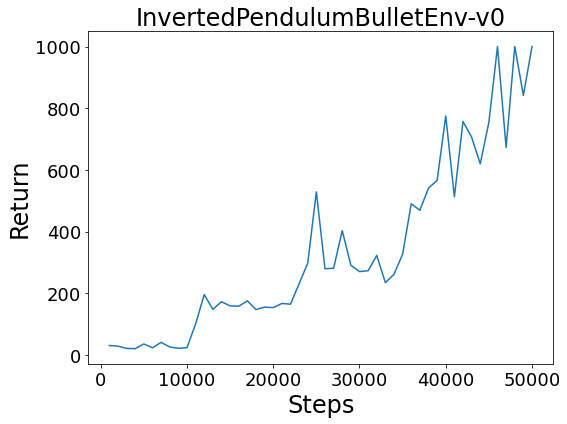

In [41]:
trainer.plot()

In [42]:
trainer.visualize()

In [43]:
del env
del env_test
del algo
del trainer

#### HalfCheetahBulletEnv-v0

次に，`HalfCheetahBulletEnv-v0` でSACを $10^6$ ステップ学習させてみましょう！ここでは，報酬のスケーリング係数は $5.0$ とします．ただし，学習には3〜4時間ほどかかるので，`HalfCheetahBulletEnv-v0` での学習は自宅での宿題とします．うまく学習できると，2300〜2800程度の平均収益に達します．

In [44]:
ENV_ID = 'HalfCheetahBulletEnv-v0'
SEED = 0
REWARD_SCALE = 5.0

NUM_STEPS = 10 ** 6
EVAL_INTERVAL = 10 ** 4

env = gym.make(ENV_ID)
env_test = gym.make(ENV_ID)

algo = SAC(
    state_shape=env.observation_space.shape,
    action_shape=env.action_space.shape,
    seed=SEED,
    reward_scale=REWARD_SCALE
)

trainer = Trainer(
    env=env,
    env_test=env_test,
    algo=algo,
    seed=SEED,
    num_steps=NUM_STEPS,
    eval_interval=EVAL_INTERVAL,
)

In [45]:
trainer.train()

Num steps: 10000    Return: -1389.7   Time: 0:00:13
Num steps: 20000    Return: -455.1   Time: 0:01:40
Num steps: 30000    Return: 150.6   Time: 0:03:06
Num steps: 40000    Return: 652.8   Time: 0:04:33
Num steps: 50000    Return: 785.8   Time: 0:05:59
Num steps: 60000    Return: 786.5   Time: 0:07:26
Num steps: 70000    Return: 749.2   Time: 0:08:52
Num steps: 80000    Return: 761.2   Time: 0:10:19
Num steps: 90000    Return: 786.2   Time: 0:11:46
Num steps: 100000   Return: 859.4   Time: 0:13:13
Num steps: 110000   Return: 798.1   Time: 0:14:40
Num steps: 120000   Return: 868.8   Time: 0:16:07
Num steps: 130000   Return: 963.2   Time: 0:17:34
Num steps: 140000   Return: 1013.6   Time: 0:19:00
Num steps: 150000   Return: 1227.6   Time: 0:20:27
Num steps: 160000   Return: 1169.3   Time: 0:21:54
Num steps: 170000   Return: 904.6   Time: 0:23:21
Num steps: 180000   Return: 1335.7   Time: 0:24:47
Num steps: 190000   Return: 1432.3   Time: 0:26:13
Num steps: 200000   Return: 1419.6   Time:

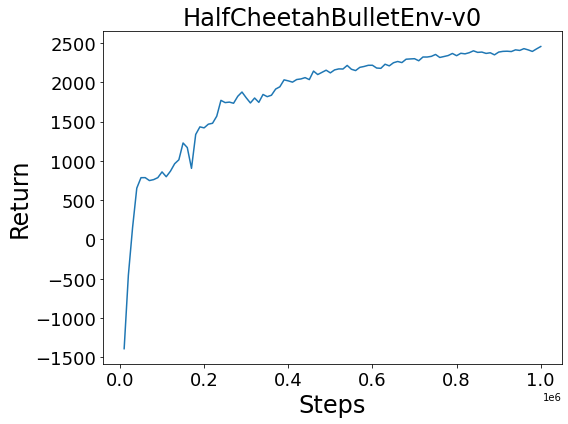

In [46]:
trainer.plot()

In [47]:
trainer.visualize()

In [48]:
del env
del env_test
del algo
del trainer

### 4.4 発展課題

- エントロピー係数 $\alpha$ の自動最適化[[3]](#scrollTo=HOq7n-OJboPr)を実装してみよう！


## 5.参考文献

[[1]](https://arxiv.org/abs/1707.06347) Schulman, John, et al. "Proximal policy optimization algorithms." arXiv preprint arXiv:1707.06347 (2017).

[[2]](https://arxiv.org/abs/1801.01290) Haarnoja, Tuomas, et al. "Soft actor-critic: Off-policy maximum entropy deep reinforcement learning with a stochastic actor." arXiv preprint arXiv:1801.01290 (2018).

[[3]](https://arxiv.org/abs/1812.05905) Haarnoja, Tuomas, et al. "Soft actor-critic algorithms and applications." arXiv preprint arXiv:1812.05905 (2018).

[[4]](https://arxiv.org/abs/1506.02438) Schulman, John, et al. "High-dimensional continuous control using generalized advantage estimation." arXiv preprint arXiv:1506.02438 (2015).

[[5]](https://arxiv.org/abs/2006.05990) Andrychowicz, Marcin, et al. "What Matters In On-Policy Reinforcement Learning? A Large-Scale Empirical Study." arXiv preprint arXiv:2006.05990 (2020).